In [3]:
# Imports
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# Read in NCEI data

## Creating a hail dataset
dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2007,2023)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file):
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
       
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Tornado'])
        li.append(hail_df)
df_tor = pd.concat(li, axis=0, ignore_index=True)  

hail_datetimes = np.array([])

offset = [int(i.split('-')[1]) for i in df_tor['CZ_TIMEZONE']]


for i in range(0,len(df_tor['BEGIN_TIME'])):
    mtime        = str(np.array(df_tor['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_tor['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_tor['Datetime'] = hail_datetimes
df_tor = df_tor.sort_values(by=['Datetime'], ignore_index = True)

ef_rating = df_tor['TOR_F_SCALE']
tor_lats  = df_tor['BEGIN_LAT']
tor_lons  = df_tor['BEGIN_LON']

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_

In [5]:
df_tor_drop = df_tor
df_tor_drop.drop(df_tor.index[df_tor['TOR_F_SCALE'] == 'EFU'], inplace=True)
df_tor_drop.reset_index(drop=True, inplace=True)

# Create New EF Scale integer category
test=[]
for i in range(0, len(df_tor_drop.TOR_F_SCALE), 1):
    if len(df_tor_drop.TOR_F_SCALE[i])==3:
        temp = df_tor_drop.TOR_F_SCALE[i][2:]
    else: # Accounts for old F scale ratings
        temp = df_tor_drop.TOR_F_SCALE[i][1:]
    temp = int(temp)
    test.append(temp)

df_tor_drop['EF_Rate']=test

In [6]:
cdc = pd.read_csv('SVI2018_US_COUNTY.csv')

In [7]:
# Create full FIPS

test1 = []
for i in range(0, len(df_tor_drop.CZ_FIPS), 1):
    val1 = str(df_tor_drop.CZ_FIPS[i])
    val2 = str(df_tor_drop.STATE_FIPS[i])
    if df_tor_drop.CZ_FIPS[i]<100:
        temp1 = val2+'0'+val1
        temp2 = int(temp1)
    else:
        temp1 = val2+val1
        temp2 = int(temp1)
    test1.append(temp2)

df_tor_fips = df_tor_drop
df_tor_fips['FIPS'] = test1

In [8]:
df_cdc = pd.merge(df_tor_fips, cdc, how="left", on=["FIPS"])

In [9]:
cdc_test = df_cdc[['RPL_THEMES', 'BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 'EP_MOBILE']].copy()

cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]


fatals = []

for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 'Fatal'
    else:
        f= 'Not Fatal'
    fatals.append(f)


cdc_test['Fatalities'] = fatals

cdc_test = cdc_test.drop('DEATHS_DIRECT', axis=1)

In [10]:
cdc_test_1 = cdc_test.drop('EF_Rate', axis=1)

In [11]:
# SciKit Time!

X_cdc = cdc_test_1.drop('Fatalities', axis=1)

y_cdc = cdc_test_1['Fatalities']

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cdc, y_cdc,
                                                random_state=1, train_size=0.7)

In [13]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9826522101751459

In [15]:
cdc_test2 = cdc_test

In [16]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_cdc)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_cdc)         # 4. Transform the data to two dimensions

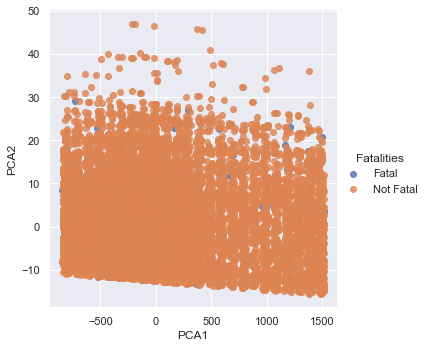

In [17]:
cdc_test2['PCA1'] = X_2D[:, 0]
cdc_test2['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='Fatalities', data=cdc_test2, fit_reg=False);

In [18]:
from sklearn.mixture import GaussianMixture      # 1. Choose the model class
model = GaussianMixture(n_components=2,
            covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(X_cdc)                    # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(X_cdc)        # 4. Determine cluster labels

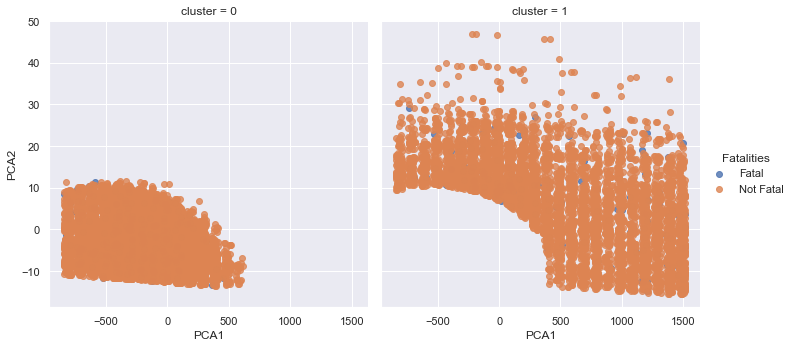

In [19]:
cdc_test2['cluster'] = y_gmm
sns.lmplot(x="PCA1", y="PCA2", data=cdc_test2, hue='Fatalities',
           col='cluster', fit_reg=False);

In [20]:
cdc_test3 = cdc_test2
cdc_test3 = cdc_test3.drop('PCA1', axis=1)
cdc_test3 = cdc_test3.drop('PCA2', axis=1)
cdc_test3 = cdc_test3.drop('cluster', axis=1)
cdc_test3

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE,Fatalities
0,0.9605,1545,1,20.7,Fatal
1,0.8475,1635,1,23.8,Not Fatal
2,0.8920,27,1,21.9,Not Fatal
3,0.6045,40,0,21.3,Not Fatal
4,0.9213,57,1,23.1,Not Fatal
...,...,...,...,...,...
21280,0.5153,1529,0,13.3,Not Fatal
21281,0.3121,940,2,7.6,Not Fatal
21283,0.6159,2135,1,2.4,Not Fatal
21284,0.4245,2137,1,14.7,Not Fatal


In [21]:
# Repeat Data Creation Process

In [22]:
df_cdc

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_x,STATE_FIPS,...,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,200701,4,1545,200701,4,1552,2664,13767,LOUISIANA,22,...,0.0,1.0,0.0,1.0,3.0,8365.0,780.0,11.6,1.1,67630.0
1,200701,4,1635,200701,4,1640,2442,12265,LOUISIANA,22,...,1.0,0.0,0.0,1.0,2.0,2781.0,432.0,12.6,2.0,17365.0
2,200701,5,27,200701,5,29,1418,6920,MISSISSIPPI,28,...,0.0,0.0,0.0,0.0,1.0,7237.0,722.0,10.7,1.1,70178.0
3,200701,5,40,200701,5,42,2543,12831,MISSISSIPPI,28,...,1.0,0.0,0.0,1.0,1.0,2376.0,455.0,13.4,2.5,17962.0
4,200701,5,57,200701,5,101,1418,6925,MISSISSIPPI,28,...,1.0,0.0,0.0,1.0,3.0,2427.0,415.0,11.4,1.9,18638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21281,202207,28,940,202207,28,955,172344,1046201,NEW YORK,36,...,0.0,0.0,0.0,0.0,0.0,1576.0,225.0,4.2,0.6,34806.0
21282,202207,28,1735,202207,28,1745,172129,1044937,CONNECTICUT,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21283,202207,28,2135,202207,28,2137,170571,1034542,OKLAHOMA,40,...,0.0,0.0,0.0,1.0,1.0,89576.0,1631.0,14.0,0.3,636846.0
21284,202207,28,2137,202207,28,2144,170571,1034543,OKLAHOMA,40,...,0.0,0.0,0.0,0.0,0.0,8863.0,505.0,11.4,0.7,46808.0


In [23]:
cdc_test = df_cdc[['RPL_THEMES', 'BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 'EP_MOBILE']].copy()

cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]


fatals = []

for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 1
    else:
        f= 0
    fatals.append(f)


cdc_test['Fatalities'] = fatals

cdc_test = cdc_test.drop('DEATHS_DIRECT', axis=1)

In [24]:
cdc_test

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE,Fatalities
0,0.9605,1545,1,20.7,1
1,0.8475,1635,1,23.8,0
2,0.8920,27,1,21.9,0
3,0.6045,40,0,21.3,0
4,0.9213,57,1,23.1,0
...,...,...,...,...,...
21280,0.5153,1529,0,13.3,0
21281,0.3121,940,2,7.6,0
21283,0.6159,2135,1,2.4,0
21284,0.4245,2137,1,14.7,0


In [25]:
# SciKit Time!

X_cdc = cdc_test.drop('Fatalities', axis=1)

y_cdc = cdc_test['Fatalities']

In [26]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cdc, y_cdc,
                                                random_state=0, train_size=0.7)

In [27]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(Xtrain, ytrain)

test_model = model.predict(Xtest)

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R2 = r2_score(ytest, test_model)
RMSE = (mean_squared_error(ytest, test_model))**0.5

print(f'r-squared: {R2}')
print(f'RMSE: {RMSE}')

r-squared: 0.13428968188356372
RMSE: 0.1281674766810264


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [30]:
param_grid = {'polynomialfeatures__degree': np.arange(10)}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [31]:
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [32]:
grid.best_params_

{'polynomialfeatures__degree': 3}

In [33]:
model = grid.best_estimator_

test_model = model.fit(Xtrain, ytrain).predict(Xtest)

R2 = r2_score(ytest, test_model)
RMSE = (mean_squared_error(ytest, test_model))**0.5

print(f'r-squared: {R2}')
print(f'RMSE: {RMSE}')

r-squared: 0.27247850680572605
RMSE: 0.11749366509470835


In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, n_estimators=200, min_samples_leaf=4, min_samples_split=10, max_depth=10)

model.fit(Xtrain, ytrain)

test_model = model.predict(Xtest)

In [35]:
R2 = r2_score(ytest, test_model)
RMSE = (mean_squared_error(ytest, test_model))**0.5

print(f'r-squared: {R2}')
print(f'RMSE: {RMSE}')

r-squared: 0.27040740120280904
RMSE: 0.11766078651331953


In [36]:
# param_grid = {'bootstrap': [True, False],  
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
#               'max_features': ['auto', 'sqrt'],  
#               'min_samples_leaf': [1, 2, 4],  
#               'min_samples_split': [2, 5, 10],  
#               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [37]:
# Another Test

In [38]:
X_cdc

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE
0,0.9605,1545,1,20.7
1,0.8475,1635,1,23.8
2,0.8920,27,1,21.9
3,0.6045,40,0,21.3
4,0.9213,57,1,23.1
...,...,...,...,...
21280,0.5153,1529,0,13.3
21281,0.3121,940,2,7.6
21283,0.6159,2135,1,2.4
21284,0.4245,2137,1,14.7


In [39]:
X_cdc_test = X_cdc.drop('EP_MOBILE', axis=1)
X_cdc_test = X_cdc_test.drop('BEGIN_TIME', axis=1)
#_cdc_test = X_cdc_test.drop('RPL_THEMES', axis=1)

In [40]:
X_cdc_test

,RPL_THEMES,EF_Rate
0,0.9605,1
1,0.8475,1
2,0.8920,1
3,0.6045,0
4,0.9213,1
...,...,...
21280,0.5153,0
21281,0.3121,2
21283,0.6159,1
21284,0.4245,1


In [41]:
from sklearn.model_selection import train_test_split
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X_cdc_test, y_cdc,
                                                random_state=0, train_size=0.7)

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

model = PolynomialRegression(degree=3)

model.fit(Xtrain1, ytrain1)

test_model = model.predict(Xtest1)

In [43]:
R2 = r2_score(ytest1, test_model)
RMSE = (mean_squared_error(ytest1, test_model))**0.5

print(f'r-squared: {R2}')
print(f'RMSE: {RMSE}')

r-squared: 0.2748362279497568
RMSE: 0.11730312632575218


3rd degree polynomial with all parameters:

- r-squared: 0.2857649835616809
- RMSE: 0.1106959785104333

Minus EF Rate:

- r-squared: -0.0031157042312057737
- RMSE: 0.13118578827138838

Minus RPL Themes:

- r-squared: 0.2860006829097672
- RMSE: 0.11067771202794029

Minus Time:
- r-squared: 0.28400180343761183
- RMSE: 0.11083252785224242

Minus Mobile Homes:
- r-squared: 0.2873475174408471
- RMSE: 0.11057327570480183

Just EF Rate:
- r-squared: 0.2820573241164449
- RMSE: 0.11098292308960543

In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [45]:
# Let's do some grouping...

In [46]:
X_cdc_test = X_cdc

In [47]:
X_cdc_test

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE
0,0.9605,1545,1,20.7
1,0.8475,1635,1,23.8
2,0.8920,27,1,21.9
3,0.6045,40,0,21.3
4,0.9213,57,1,23.1
...,...,...,...,...
21280,0.5153,1529,0,13.3
21281,0.3121,940,2,7.6
21283,0.6159,2135,1,2.4
21284,0.4245,2137,1,14.7


In [48]:
test = []

for i in X_cdc_test.BEGIN_TIME:
    if i <= 600:
        f = 1
    elif i >= 2200:
        f = 1
    else:
        f= 0
    test.append(f)


X_cdc_test['NIGHT'] = test

X_cdc_test = X_cdc_test.drop('BEGIN_TIME', axis=1)

In [49]:
# test = []

# for i in X_cdc_test.EP_MOBILE:
#     if i >= 20:
#         f = 1
#     else:
#         f= 0
#     test.append(f)

# X_cdc_test['MOBILE'] = test

X_cdc_test = X_cdc_test.drop('EP_MOBILE', axis=1)

In [50]:
X_cdc_test

,RPL_THEMES,EF_Rate,NIGHT
0,0.9605,1,0
1,0.8475,1,0
2,0.8920,1,1
3,0.6045,0,1
4,0.9213,1,1
...,...,...,...
21280,0.5153,0,0
21281,0.3121,2,0
21283,0.6159,1,0
21284,0.4245,1,0


In [51]:
from sklearn.model_selection import train_test_split
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X_cdc_test, y_cdc,
                                                random_state=0, train_size=0.7)

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

model = PolynomialRegression(degree=3)

model.fit(Xtrain1, ytrain1)

test_model = model.predict(Xtest1)

In [53]:
R2 = r2_score(ytest1, test_model)
RMSE = (mean_squared_error(ytest1, test_model))**0.5

print(f'r-squared: {R2}')
print(f'RMSE: {RMSE}')

r-squared: 0.2726585086881409
RMSE: 0.11747912917417942


With binned times:
- r-squared: 0.2903540753474815
- RMSE: 0.11033978439028035

With binned times and mobile homes:
- r-squared: 0.2900407481039413
- RMSE: 0.11036414065301342

Binned times, dropped mobile homes:
- r-squared: 0.29034722694542725
- RMSE: 0.11034031680324627

In [54]:
# Max of the model is right at least
# Well it used to be...

In [55]:
test_model.argmax()

1391

In [56]:
print(test_model[1391])
print(ytest1.iloc[1391])

1.1662861642349078
0


In [57]:
example = pd.DataFrame(columns=['RPL_THEMES', 'EF_Rate', 'NIGHT'])
example.RPL_THEMES = [0.8]
example.EF_Rate = [3]
example.NIGHT = [1]
example

,RPL_THEMES,EF_Rate,NIGHT
0,0.8,3,1


In [58]:
out = model.predict(example)
out

array([0.38968183])

In [59]:
print('Vulnerability Index (0-100)')
vulnerable = input()
vulnerable = int(vulnerable)
print(f'Vulnerability: {vulnerable}')
print('EF Rating (0-5)')
rate = input()
rate = int(rate)
print(f'EF Rating: {rate}')
print('Nighttime Tornado? (1 for yes, 0 for no)')
night = input()
night = int(night)
if night == 1:
    h = 'yes'
elif night ==0:
    h = 'no'
else:
    h = 'error'
print(f'Nighttime? {h}')

vulnerable = vulnerable/100
example = pd.DataFrame(columns=['RPL_THEMES', 'EF_Rate', 'NIGHT'])
example.RPL_THEMES = [vulnerable]
example.EF_Rate = [rate]
example.NIGHT = [night]
example

out = model.predict(example)
print(f'{out[0]*100}%')

Vulnerability Index (0-100)
Vulnerability: 100
EF Rating (0-5)
EF Rating: 5
Nighttime Tornado? (1 for yes, 0 for no)
Nighttime? yes
168.07513363941104%


In [60]:
# To do: add population density (total pop/area)
# Add one hot encoding for seasons (cool vs warm or four seasons)

In [61]:
# First pass at feature importance

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=True, n_estimators=200, min_samples_leaf=4, min_samples_split=10, max_depth=10)

forest.fit(Xtrain1, ytrain1)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200)

In [63]:
ypredict = forest.predict(Xtest1)

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

R2 = r2_score(ytest1, ypredict)
print(f'The correlation coefficient of the model is {R2}')
RMSE = (mean_squared_error(ytest, ypredict))**0.5
print(f'The RMSE of the model is {RMSE}')

The correlation coefficient of the model is 0.22224437137669284
The RMSE of the model is 0.12148233158946378


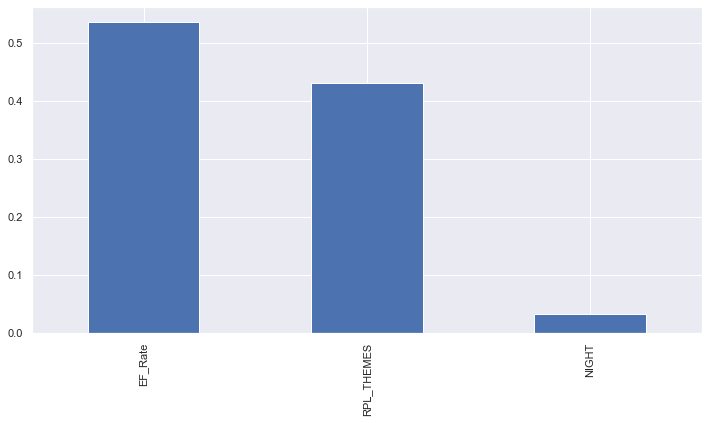

In [65]:
importances = pd.Series(forest.feature_importances_)

importances.index = X_cdc_test.columns
importances.sort_values(inplace=True, ascending=False)
importances.plot.bar(figsize=(12,6))
plt.show()

In [69]:
# SHAP
import shap

shap.initjs()

In [66]:
explainer = shap.Explainer(forest)
shap_test = explainer(Xtest1)

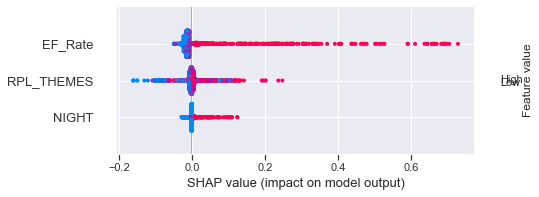

In [67]:
shap.summary_plot(shap_test)

In [87]:
shap.plots.force(shap_test[70])

In [72]:
# Try xgboost too